# Radiant Environment Maps

Radiant Environment Maps (REMs, also called "light-probes" or "skydomes" in different contexts) define the amount of light (radiance) travelling in all directions at a point in the Earth atmosphere. REMs can be computed using libRadtran with the radiance options ('umu' and 'phi') that allow specification of the directions in which one would like to compute the radiance. Most of the solvers in libRadtran can compute radiances, including all the variants of DISORT. One the basic capabilities in MORTICIA is to compute REMs and then to compute ("render") the appearance of targets in a specific radiant environment. This notebook illustrates the computation of REMs using libRadtran.

libRadtran has a number of k-distribution (also called "correlated-k") atmospheric absorption parametrizations. These models allow for more rapid computation of radiances and irradiances, but with limited spectral resolution. One such model for the shortwave spectrum is that by Kato et. al. For the thermal spectrum, there is the Fu parametrization. Read the libRadtran manual for more details. Here, we will use the Kato model to compute the sky/ground appearance as provided by a REM.

The MORTICIA class used for REM computation is morticia.rad.librad.RadEnv.

In [1]:
import morticia.rad.librad as librad
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.rad.librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller

%matplotlib inline

In [2]:
# Load a libRadtran example case
# Be default, any include files are expanded, creating a single set of option keywords
libRadCaseA=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseA.alter_option(['albedo', '0.5'])
libRadCaseA.alter_option(['phi0', '0.0'])
libRadCaseA.alter_option(['wavelength', '500.0'])
libRadCaseA.alter_option(['zout', 'boa','0.5', '5.0', 'toa'])
#libRadCaseA.alter_option(['number_of_streams', '32'])
#libRadCaseA.alter_option(['pseudospherical', ''])
libRadCaseA.alter_option(['zout_interpolate'])
libRadCaseB=librad.Case(filename='./examples/UVSPEC_AEROSOL_1WVL.INP')
libRadCaseB.alter_option(['albedo', '0.5'])
libRadCaseB.alter_option(['phi0', '45.0'])


In [3]:
# Build a radiant environment map case
libRadEnvh = librad.RadEnv(base_case=libRadCaseA, n_pol=256, n_azi=128, hemi=True, n_sza=20)
libRadEnvf = librad.RadEnv(base_case=libRadCaseB, n_pol=256, n_azi=256, hemi=False)

In [4]:
# Create a client and connect to the profile defined when the ipyparallel controller hub was started
# The file was created on the cluster host (called icebow) in the file
# \\146.64.246.95\dgriffith\.ipython\profile_default\security\ipcontroller-client.json
# This file must be copied (*every* time the ipcontroller is restarted) to the localhost e.g. to
# C:\Users\DGriffith\.ipython\profile_icebow\security\ipcontroller-client.json
paraclient = Client(profile='f2', sshserver='dgriffith@f2.csir.co.za', password='mandamoggie')

In [5]:
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [6]:
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True

In [7]:
%time libRadEnvh.run_ipyparallel(ipyparallel_view=paraview)
#%time libRadEnvf.run_ipyparallel(ipyparallel_view=paraview)

Wall time: 3.62 s


In [17]:
import dill

In [18]:
dill.dump(libRadEnvh, open( "libRadEnvh.dill", "wb" ) )
#dill.dump(libRadEnvf, open( "libRadEnvf.dill", "wb" ) )

In [3]:
with open("libRadEnvh.dill", 'rb') as in_strm:
     libRadEnvh = dill.load(in_strm)

In [8]:
N = 4
# %time shh = libRadEnvh.sph_harm_fit(degree=N, method='trapz')
shh = libRadEnvh.sph_harm_fit(degree=N, method='trapz')
# %time shf = libRadEnvf.sph_harm_fit(degree=N, method='trapz')
shf = libRadEnvf.sph_harm_fit(degree=N, method='trapz')

AttributeError: 'RadEnv' object has no attribute 'xd_uu'

In [ ]:
for n in range(N+1):
    for m in range(n+1):
        print 'n = ', n, '  m = ', m, ' :  ', shh[n][m].mean().data, '   ', shf[n][m].mean().data

In [ ]:
c = librad.Case(filename='./examples/UVSPEC_CLOUDCOVER_REDISTRIBUTION.INP')
c.alter_option(['cloudcover', 'wc', '0.0'])
cenv = librad.RadEnv(base_case=c, n_pol=256, n_azi=128, hemi=True, n_sza=48)

In [9]:
range(libRadEnvh.n_levels_out)

[0, 1, 2, 3]

In [ ]:
cenv.trans_base_case

In [ ]:
plt.plot(cenv.trans_vza_up.data)

In [ ]:
cenv.trans_vza_up

In [ ]:
cenv.trans_cases[1].outfile

In [13]:
libRadEnvh.compute_path_transmittance()
libRadEnvh.compute_path_radiance()

(83.9, 84.8)

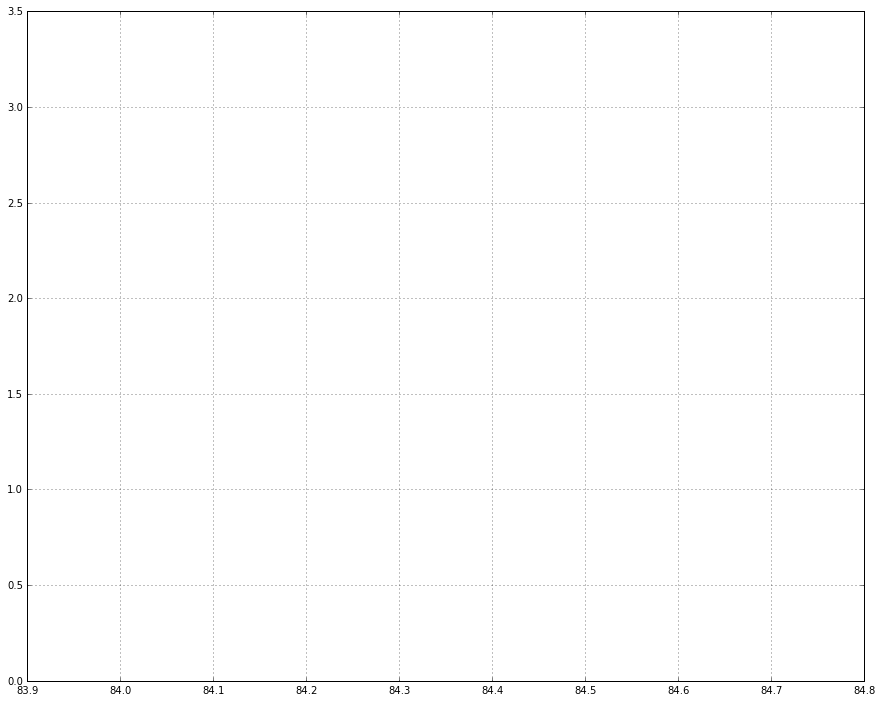

In [14]:
plt.figure(figsize=(15, 12))
plt.plot(np.rad2deg(libRadEnvh.xd_opt_depth['pza'].data), libRadEnvh.xd_opt_depth[:,:,1].data)
plt.grid()
plt.ylim([0.0,3.5])
plt.xlim([83.9, 84.8])

(0.0, 10.0)

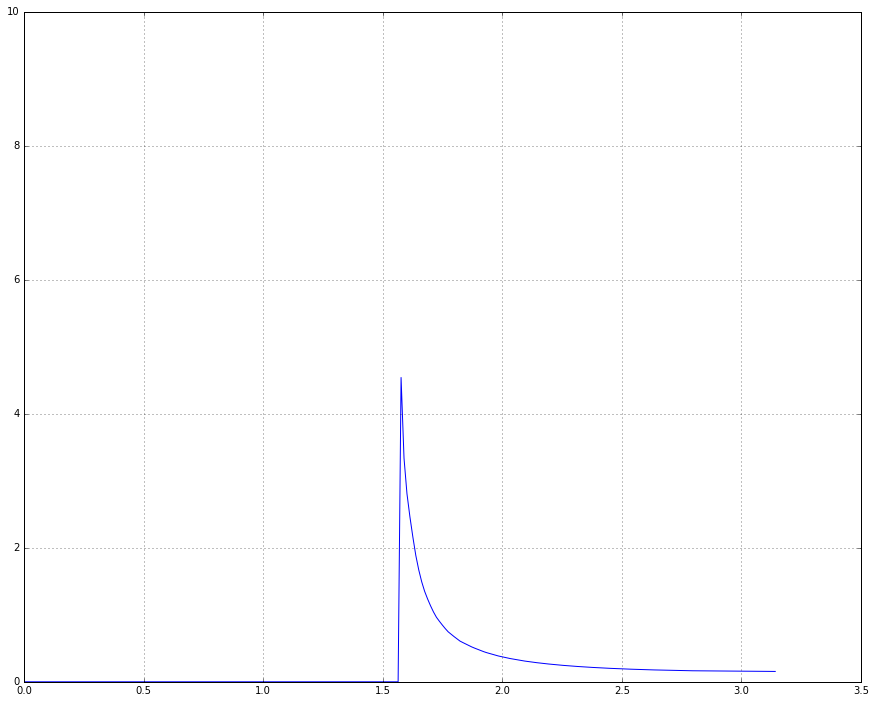

In [9]:
plt.figure(figsize=(15, 12))
plt.plot(libRadEnvh.xd_opt_depth['pza'].data, libRadEnvh.xd_opt_depth[:,0,3].data)
plt.grid()
plt.ylim([0.0,10.0])

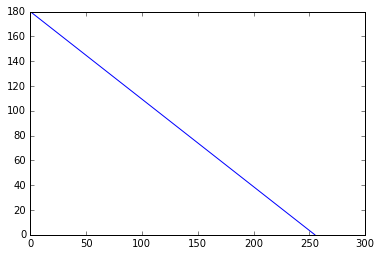

In [52]:
plt.plot(np.rad2deg(libRadEnvh.xd_opt_depth['pza'].data))

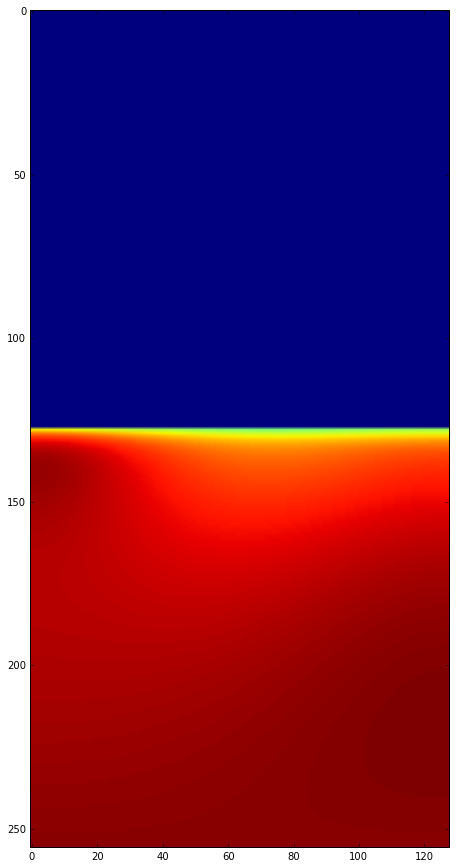

In [9]:
plt.figure(figsize=(10, 15))
plt.imshow(libRadEnvh.xd_uu[:,:,0,3,0])


In [10]:
libRadEnvh.xd_uu.dims


('pza', 'paz', 'wvl', 'zout', 'stokes')

In [13]:
libRadEnvh.xd_uu_times_tau.dims

('pza', 'wvl', 'zout', 'paz', 'stokes')

In [ ]:
x1 = xray.DataArray([1.0,libRadEnvh.xd_edir.data[1,0,1]], [([0.0, 1.0])])

In [ ]:
x2 = xray.DataArray([5.0,6.0], [([0.0, np.inf])])

In [ ]:
x1+x2

In [ ]:
wierd = libRadEnvh.xd_edir.data[1,0,1]

In [ ]:
plt.plot([0.0, 1.0], [1.0, wierd])

In [ ]:
wierd

In [ ]:
wierd

In [ ]:
wierd

In [ ]:
libRadEnvh.xd_edir.plot()

In [ ]:
type(wierd)

In [ ]:
wierd

In [ ]:
print wierd

In [ ]:
repr(wierd)

In [ ]:
wierd1 = np.float64(repr(wierd))

In [ ]:
plt.plot([0.0, 1.0], [1.0, 0.999999999999])

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
interpolator = interp1d([0.0, 1.0], [1.0, wierd1], )

In [ ]:
newrange = np.linspace(0.0,1.0,10)

In [ ]:
interpolator(newrange)

In [ ]:
libRadEnvh.xd_opt_depth[:,0,3].data

In [ ]:
len(libRadEnvh.xd_opt_depth[libRadEnvh.levels_out_type])

In [ ]:
range(10,0,-1)

In [ ]:
dict(space=0)

In [ ]:
-np.log(0.9)

In [269]:
libRadEnvh.xd_opt_depth[:,0,0].data

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [69]:
libRadEnvh.xd_opt_depth

<xray.DataArray (pza: 256, wvl: 1, zout: 4)>
array([[[  2.22014851e-01,   2.05929887e-01,   1.54751644e-01,
          -1.55431223e-15]],

       [[  2.22050814e-01,   2.05020140e-01,   1.55098240e-01,
           1.74113003e-08]],

       [[  2.22120605e-01,   2.04195700e-01,   1.55451652e-01,
           3.39981148e-08]],

       ..., 
       [[ -0.00000000e+00,   2.22120605e-01,   2.04195700e-01,
           1.55451652e-01]],

       [[ -0.00000000e+00,   2.22050814e-01,   2.05020140e-01,
           1.55098240e-01]],

       [[ -0.00000000e+00,   2.22014851e-01,   2.05929887e-01,
           1.54751644e-01]]])
Coordinates:
  * pza      (pza) float64 3.142 3.129 3.117 3.105 3.092 3.08 3.068 3.055 ...
  * wvl      (wvl) float64 500.0
  * zout     (zout) float64 0.0 1.0 5.0 inf

In [15]:
libRadEnvh.path_radiance['zout']

<xray.DataArray 'zout' (zout: 12)>
array([  0.,   1.,   5.,  inf,   0.,   1.,   5.,  inf,   0.,   1.,   5.,
        inf])
Coordinates:
  * zout     (zout) float64 0.0 1.0 5.0 inf 0.0 1.0 5.0 inf 0.0 1.0 5.0 inf
Attributes:
    units: km
    long_name: Height Above Surface

<function matplotlib.pyplot.colorbar>

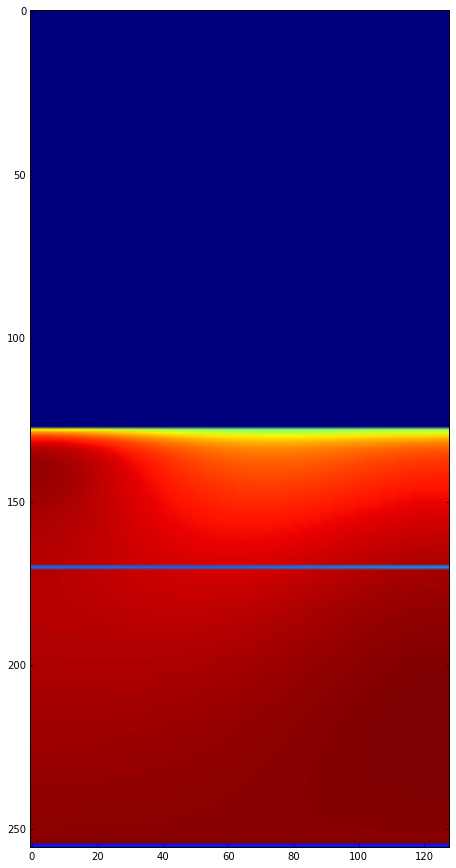

In [15]:
plt.figure(figsize=(15, 15))
plt.imshow(libRadEnvh.xd_path_radiance[:,:,0,3,0])
plt.colorbar

(0.0, 1.1)

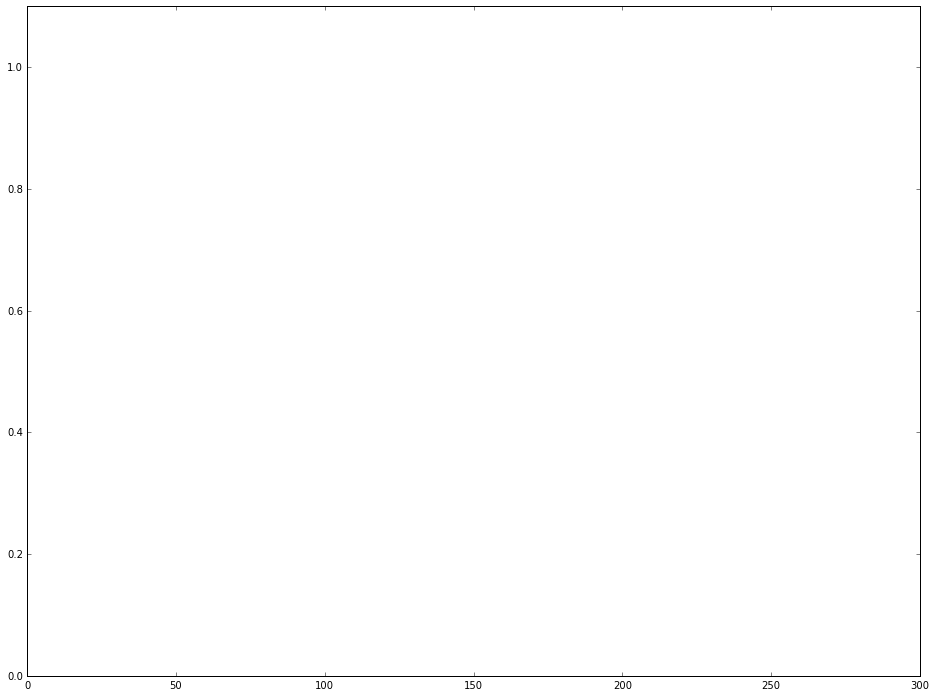

In [12]:
plt.figure(figsize=(16,12))
plt.plot(libRadEnvh.xd_trans[:,0,0])
plt.ylim([0.0, 1.1])

In [46]:
np.rad2deg(libRadEnvh.xd_edir['pza'])

<xray.DataArray (pza: 10)>
array([  0.        ,  25.84193276,  36.86989765,  45.572996  ,
        53.13010235,  60.        ,  66.42182152,  72.54239688,
        78.46304097,  84.26082952])
Coordinates:
  * pza      (pza) float64 0.0 0.451 0.6435 0.7954 0.9273 1.047 1.159 1.266 ...

In [68]:
len(libRadEnvh.xd_uu['pza'])

256

In [120]:
np.minimum([-5, -3], [np.inf, -8])

array([-5., -8.])

In [298]:
np.rad2deg(libRadEnvh.xd_uu['pza'])

<xray.DataArray (pza: 256)>
array([ 180.        ,  179.29411765,  178.58823529,  177.88235294,
        177.17647059,  176.47058824,  175.76470588,  175.05882353,
        174.35294118,  173.64705882,  172.94117647,  172.23529412,
        171.52941176,  170.82352941,  170.11764706,  169.41176471,
        168.70588235,  168.        ,  167.29411765,  166.58823529,
        165.88235294,  165.17647059,  164.47058824,  163.76470588,
        163.05882353,  162.35294118,  161.64705882,  160.94117647,
        160.23529412,  159.52941176,  158.82352941,  158.11764706,
        157.41176471,  156.70588235,  156.        ,  155.29411765,
        154.58823529,  153.88235294,  153.17647059,  152.47058824,
        151.76470588,  151.05882353,  150.35294118,  149.64705882,
        148.94117647,  148.23529412,  147.52941176,  146.82352941,
        146.11764706,  145.41176471,  144.70588235,  144.        ,
        143.29411765,  142.58823529,  141.88235294,  141.17647059,
        140.47058824,  139.7647058

In [297]:
np.rad2deg(libRadEnvh.xd_edir['pza'])

<xray.DataArray (pza: 21)>
array([  0.        ,  18.19487234,  25.84193276,  31.78833062,
        36.86989765,  41.40962211,  45.572996  ,  49.45839813,
        53.13010235,  56.63298703,  60.        ,  63.25631605,
        66.42182152,  69.51268489,  72.54239688,  75.52248781,
        78.46304097,  81.37307344,  84.26082952,  87.13401602,  89.29411765])
Coordinates:
  * pza      (pza) float64 0.0 0.3176 0.451 0.5548 0.6435 0.7227 0.7954 ...

In [293]:
libRadEnvh.xd_edir[:,0,0].data

array([  5.58390700e-01,   5.41554500e-01,   5.23447300e-01,
         5.03931800e-01,   4.82853100e-01,   4.60038300e-01,
         4.35295000e-01,   4.08412200e-01,   3.79164500e-01,
         3.47321400e-01,   3.12706300e-01,   2.75037900e-01,
         2.34402500e-01,   1.90994800e-01,   1.45571900e-01,
         9.98519800e-02,   5.71865700e-02,   2.31569000e-02,
         4.22010600e-03,   5.85628500e-05,   1.87852100e-10])

In [299]:
90-0.70588235

89.29411765

In [408]:
level = 3
print (libRadEnvh.xd_path_radiance[:,:,0,level,0] / libRadEnvh.xd_uu[:,:,0,level,0]).max()
print (libRadEnvh.xd_path_radiance[:,:,0,level,0] / libRadEnvh.xd_uu[:,:,0,level,0]).mean()

<xray.DataArray 'specrad' ()>
array(0.9814461227975587)
Coordinates:
    stokes   int64 0
    zout     float64 inf
    wvl      float64 500.0
<xray.DataArray 'specrad' ()>
array(0.2916997310191807)
Coordinates:
    stokes   int64 0
    zout     float64 inf
    wvl      float64 500.0


In [443]:
libRadEnvh.xd_trans.data.max()

1.0